# P3 Unsupervised Learning: Clustering FOMC Meeting Texts

---

## Overview
In this jupyter notebook, I ingests a cleaned FOMC minutes dataset, transforms the text into numerical representations, discovers latent groups via multiple clustering methods, visualizes the resulting structures, enriches each document with sentiment and topic features, and finally evaluates how those clusters relate to the “new_orders_manufacturing” variable. Throughout, it alternates between TF–IDF, SVD, UMAP, K‐Means, HDBSCAN, and BERTopic embeddings, then assesses cluster stability, computes sentiment scores with FinBERT, and runs statistical tests to quantify performance.

### 1. Setup and Library Imports

At the start we import pandas and NumPy for data handling, regular expressions and the string module for text cleaning, matplotlib and Plotly Express for visualization, scikit-learn classes for TF–IDF vectorization, dimensionality reduction, clustering, silhouette scoring, isolation forest, and local outlier factor. We also import BERTopic and SentenceTransformer for advanced topic modeling, HDBSCAN and UMAP for density‐based clustering and manifold learning, and extend scikit-learn’s English stopword list for domain‐specific text filtering. This prepares all the tools needed for the entire pipeline.

In [1]:
import pandas as pd, numpy as np, re, string, matplotlib.pyplot as plt, plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import hdbscan, umap
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

### 2. Data Loading and Preprocessing

In [2]:
df     = pd.read_csv("clean_data.csv")
# drop all empty rows in minute_text
df     = df.dropna(subset=["minute_text"])
docs   = df["minute_text"].astype(str).tolist()
dates  = pd.to_datetime(df["Date"])

### 3. Custom Stopword Construction

Next, I merge scikit-learn’s built-in English stopwords with a manually curated list of FOMC-specific terms that add noise—words such as “committee,” “meeting,” and various personal or year tokens. This composite list, stored in custom_stops, will be supplied to all my vectorizers so that I focus on the most informative phrases rather than boilerplate procedural language.

In [3]:
custom_stops = list(ENGLISH_STOP_WORDS) + ["the","of","in","and","to",
    "mr","committee","meeting","minutes","federal",
    "ms","fomc","bank","policy","members",
    "faster","quarter","previous","fell","august",
    "balance","year","percent","board","term", "target", "range", "funds", 
    "messrs", "hoenig", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
    "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015",
    "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023",
    "2024", "2025", "forward", "guidance", "kohn", "mcdonough", "bernanke",
    "al", "rrp", "poole", "minehan", "santomero", "january", "feburary", "march",
    "april", "may", "june", "july", "august", "september", "october", "november",
    "december", "subcommittee", "chairman", "first", "second", "third", "fourth",
    "fifth", "sixth", "seventh", "eighth", "ninth", "tenth", "eleventh"]

### 4. TF–IDF Vectorization and Cluster-Number Search

Using the custom stopwords, a TfidfVectorizer with up to 25,000 features, unigrams and bigrams, a minimum document frequency of five, and a maximum document frequency of 75% is fitted to the meeting texts. The resulting sparse matrix X has one row per document and one column per term. To select an appropriate number of clusters, we loop k from 2 to 14, fitting a K-Means model each time and recording the inertia (sum of squared errors) and the mean silhouette score. These metrics populate the lists SSE and SIL, while ks tracks each tested k value.

In [4]:
tfidf = TfidfVectorizer(
    max_features=25_000,
    ngram_range=(1,2),
    stop_words=custom_stops,
    min_df=5,
    max_df=0.75
)
X = tfidf.fit_transform(docs)

In [5]:
ks, sse, sil = [], [], []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
    ks.append(k)
    sse.append(km.inertia_)                       # Sum of squared errors
    sil.append(silhouette_score(X, km.labels_))   # Mean silhouette coefficient

# Elbow plot
fig_elbow = px.line(
    x=ks, y=sse, markers=True,
    labels={"x":"k (clusters)", "y":"SSE"},
    title="Elbow Plot"
)
fig_elbow.show()

In [6]:
# Silhouette plot
fig_sil = px.line(
    x=ks, y=sil, markers=True,
    labels={"x":"k (clusters)", "y":"Silhouette Score"},
    title="Silhouette Scores"
)
fig_sil.show()

When I plot the sum of SSE against increasing k, the rate of decline in SSE is steep up through $k = 8$ but begins to flatten thereafter.  At the same time, the average silhouette coefficient (which measures how well each point lies within its assigned cluster versus its nearest neighbor cluster) achieves one of its highest values at $k = 8$, suggesting that eight groups strike the best balance between internal cohesion and separation across clusters.  Finally, inspection of the resulting cluster sizes shows no overly small or overly large segment at $k = 8$, which supports interpretability: each cluster contains enough meetings to yield stable term–weight profiles and meaningful aggregate statistics without diluting distinct rhetorical regimes. Taken together, the elbow in SSE, the peak in silhouette score, and the practical balance of cluster cardinalities all point to $k = 8$ as the most judicious choice for our K-Means partitioning of FOMC texts.

### 6. K-Means Clustering and Label Assignment

Choosing `best_k = 8`, the script fits a final K-Means model on the TF–IDF matrix and writes the resulting integer labels into a new column k8_cluster in df. A quick printout of the value counts by cluster confirms how many meetings fall into each of the eight groups, preparing the data for downstream analysis.

In [7]:
best_k = 8
km8 = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto"
).fit(X)

# Attach labels & cluster sizes
labels8 = km8.labels_
df["k8_cluster"] = labels8

print("Cluster sizes (k=8):")
print(pd.Series(labels8).value_counts().sort_index())

Cluster sizes (k=8):
0    26
1    26
2    31
3    35
4    24
5    33
6    14
7    23
Name: count, dtype: int64


### 7. Extracting Top Terms per Cluster

To understand what each K-Means cluster represents, I retrieve the TF–IDF feature names and the 8×p cluster centroid array from the fitted model. For each cluster index from zero to seven, the ten highest-weight feature indices are identified and mapped back to their corresponding terms. These are then assembled into a DataFrame top_terms_df whose rows correspond to clusters and whose columns list the top ten defining terms in descending order of weight.

In [8]:
import pandas as pd

# 1. Get feature names from the TF-IDF vectorizer
terms = tfidf.get_feature_names_out()   # shape (p,)

# 2. Extract the cluster centers (k x p array)
centroids = km8.cluster_centers_

# 3. For each cluster, find the top N terms
top_n = 10
top_terms = {}
for cluster_idx in range(best_k):
    # argsort descending gives indices of highest-weight features
    best_feat_idxs = centroids[cluster_idx].argsort()[::-1][:top_n]
    top_terms[cluster_idx] = [terms[i] for i in best_feat_idxs]

# 4. Build a DataFrame for easy viewing
top_terms_df = pd.DataFrame.from_dict(
    top_terms, orient="index",
    columns=[f"Term {i+1}" for i in range(top_n)]
)
top_terms_df.index.name = "Cluster"
top_terms_df

,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Term 10
Cluster,,,,,,,,,,
0,shall,foreign currency,currency,currency operations,authorization,arrangements,paragraph,selected,accounts,authorized
1,objective,symmetric,longer run,based measures,reserves,desk,global,month basis,elb,repo
2,weakness,inventory,productivity,anecdotal,easing,foreseeable,foreseeable future,greenspan,gramlich,indications
3,pandemic,supply,goals,special adviser,restrictive,remarked,participants observed,pre pandemic,holdings,covid
4,½s,core inflation,hurricane,february,contained,sustainable,geithner,likely measured,inventories,accommodation removed
5,asset,recovery,program,mbs,economic recovery,backed,february,mandate,purchase,asset purchases
6,liquidity,risks growth,strains,credit conditions,headline,institutions,taf,facility,coming quarters,mortgages
7,longer run,objective,normalization,run objective,declines energy,backed securities,asset,backed,mortgage backed,based measures


I find that this raw list of top TF–IDF terms per cluster doesn’t coalesce into clear, coherent topics on its own. I’ll need to dig deeper—perhaps by experimenting with alternative clustering methods and running a BERTopic analysis—to surface more meaningful thematic structure.

### 8. Dimensionality Reduction and UMAP Visualization

Because the TF–IDF space is high-dimensional, I first apply TruncatedSVD to reduce it to 100 dimensions, yielding a dense array X100. We then project these 100-dimensional vectors into two dimensions via UMAP with a cosine metric. Plotting the resulting 2D coordinates with Plotly, each meeting is colored by its K-Means cluster label, allowing visual inspection of how well the groups separate in manifold space and how they relate over time via hoverable date annotations.

In [9]:
svd   = TruncatedSVD(n_components=100, random_state=42)
X100  = svd.fit_transform(X)

umap2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
).fit_transform(X100)

fig = px.scatter(
    x=umap2d[:,0], y=umap2d[:,1],
    color=df["k8_cluster"].astype(str),
    hover_data={"date": dates, "text": [t[:100] for t in docs]},
    title="K-Means (k=8) clusters in UMAP space"
)
fig.update_layout(legend_title="Cluster")
fig.show()

I observe that each cluster forms its own “island” or “arm” in the swirl. The red cluster on the far right stands entirely apart, which tells me those meetings share a markedly different vocabulary. Just to its left, the green cluster appears as a tight band at mid-height, with the purple cluster hovering just above it—suggesting two policy eras that are chronologically adjacent but linguistically distinct. Further left and upward, the orange, pink, and light-blue clusters trace out a smooth continuum, reflecting a gradual thematic shift over time. Finally, the lime-green cluster perched at the top is also isolated, indicating yet another discrete rhetorical regime.

Because UMAP preserves local neighborhood relationships, I’m confident that points of the same color truly lie close in the original embedding space, and the clear gaps between colors confirm that k = 8 yields well-separated groups. When I hover over points, I can see meeting dates that often align with historical phases—pre-crisis, crisis, and post-crisis—explaining why the clusters follow a continuous curved trajectory rather than appearing randomly scattered.

### 9. HDBSCAN Clustering and Visualization

An alternative density-based approach uses HDBSCAN on the same 100-dimensional SVD embeddings. After an initial run, I enable prediction data and refit with a smaller minimum cluster size of ten. The final string labels (with “–1” indicating noise) are stored in df["hdb_cluster"]. A second UMAP scatter plot then shows these density clusters in the same manifold, highlighting any groups that K-Means may have missed or split differently.

In [10]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,
                            metric='euclidean',
                            cluster_selection_method='eom')
hdb_labels = clusterer.fit_predict(X100)
df['hdb_cluster'] = hdb_labels

In [11]:
import hdbscan

# Fit HDBSCAN on 100-dim SVD embeddings
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)
hdb_labels = clusterer.fit_predict(X100)

# 2. Attach to DataFrame
df['hdb_cluster'] = hdb_labels.astype(str)

In [12]:
# visualize HDBSCAN clusters
fig_hdb = px.scatter(
    x=umap2d[:,0], y=umap2d[:,1],
    color=df["hdb_cluster"],
    hover_data={"date": dates, "text": [t[:100] for t in docs]},
    title="HDBSCAN clusters in UMAP space"
)
fig_hdb.update_layout(legend_title="Cluster")
fig_hdb.show()

I immediately notice it collapses the eight K-Means groups into just three dense islands (plus any scattered noise, if I were showing it). In the previous K-Means UMAP, I saw eight distinct “arms” fanning out—a red arm all the way on the right, a tight green band at mid-height, a purple cluster just above it, and then the orange, pink, light-blue, and lime-green branches each tracing their own curve. HDBSCAN, by contrast, has treated the long right-hand arm (formerly red, teal, and some of the mid-curve points) as one big cluster in red, it’s carved out the inner loop region as a compact blue cluster, and it’s kept the small top-branch points together in green. All of the transitional points that sat between those islands in the K-Means plot now either merge into the closest dense core or get labeled as noise (if they fell below the density threshold).

In comparing the two, I see that K-Means enforces equal-sized partitions even in sparsely populated areas of the embedding, which gives me fine-grained splits but can force some meetings into clusters that aren’t actually well supported by text density. HDBSCAN, on the other hand, only flags the most tightly knit groups and effectively says “everything else is too diffuse” (or noise) or belongs to the nearest dense region. That means I get fewer, more cohesive clusters with HDBSCAN—which is great if I want to focus on the most salient rhetorical regimes—but I lose the finer thematic distinctions that K-Means uncovered along that continuous curved trajectory.

For my research goal of mapping nuanced shifts in FOMC rhetoric to manufacturing orders, I prefer K-Means. Its eight equally sized clusters preserved the full continuum of thematic arms, whereas HDBSCAN collapsed many of those into a few dense cores or noise, losing the finer distinctions I need for detailed downstream analysis.

### 11. Custom BERTopic + K-Means Pipeline for FOMC Meeting Topic Extraction
I plan to complement my K-Means results with a BERTopic analysis, hoping its integrated embedding will yield more coherent, human-interpretable topics for each cluster. By leveraging BERTopic’s dynamic topic modeling and built-in visualization tools, I expect to uncover clearer thematic structures that map more directly onto economic narratives.

I build a custom CountVectorizer with your stopwords, and generate sentence embeddings via Sentence-Transformer plus UMAP. Then I fit BERTopic (without HDBSCAN), extract its embeddings, override its clustering with K-Means (k = 8), and write the final topic IDs and confidence scores back into the DataFrame for visualization.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# Prepare CountVectorizer with custom stops
vectorizer = CountVectorizer(
    stop_words=custom_stops,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.75
)

# Set up embeddings + UMAP
embedder   = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

# Initialize BERTopic with custom vectorizer
topic_model = BERTopic(
    embedding_model    = embedder,
    umap_model         = umap_model,
    vectorizer_model   = vectorizer,
    hdbscan_model      = None,
    calculate_probabilities = True,
    nr_topics          = "auto"
)

# Fit once to get embeddings
initial_topics, initial_probs = topic_model.fit_transform(docs)
embeddings = topic_model._extract_embeddings(docs)

# Re-cluster embeddings with KMeans (k=8)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)

# Update topics *and* re-apply the same vectorizer
topic_model.update_topics(
    docs,
    initial_topics,
    kmeans_labels,
    vectorizer_model=vectorizer    # explicitly re-use your CountVectorizer here
)

# Write results back to df
df["bertopic_km_topic"]       = topic_model.topics_
df["bertopic_km_probability"] = [max(p) for p in topic_model.probabilities_]

# Inspect & visualize
print(topic_model.get_topic_info().head(10))
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=8)

2025-05-21 09:04:41,611 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


   Topic  Count                                               Name  \
0      0     17      0_private credit_reserve sheet_agency mbs_bid   
1      1     40  1_agency mortgage_normalization_couple_based m...   
2      2     29  2_based measures_couple_inflation objective_ag...   
3      3     18     3_press_wealth effects_tech equipment_stockton   
4      4     42       4_inventory sales_nation_johnson_pace likely   
5      5     37  5_asset purchases_based measures_agency mortga...   
6      6     11  6_inflation moderate_moderate coming_tightenin...   
7      7     18  7_asset purchases_purchase program_agency mort...   

                                      Representation  \
0  [private credit, reserve sheet, agency mbs, bi...   
1  [agency mortgage, normalization, couple, based...   
2  [based measures, couple, inflation objective, ...   
3  [press, wealth effects, tech equipment, stockt...   
4  [inventory sales, nation, johnson, pace likely...   
5  [asset purchases, based measur

Now that I’ve applied BERTopic, the top terms for each topic read more like coherent economic concepts instead of generic boilerplate. I can clearly infer meaningful labels directly from these terms, which makes the clusters far more interpretable for my downstream analysis:

| Cluster | Top Terms (ex.)                                           | Proposed Topic Title                                | Reason                                                                                   |
|:-------:|:----------------------------------------------------------|:----------------------------------------------------|:-----------------------------------------------------------------------------------------|
| 0       | private credit, reserve sheet, agency mbs, tight credit   | **Credit Market Conditions**                        | I chose this because the dominant words all relate to the availability and cost of credit |
| 1       | agency mortgage, normalization, based measures             | **Mortgage Markets & Policy Normalization**         | I saw repeated references to agency MBS and “normalization,” pointing to mortgage policy |
| 2       | inflation objective, market based, based measures          | **Inflation Objectives & Market Measures**          | The top terms focus on the Fed’s inflation target and measurement approaches              |
| 3       | press, wealth effects, tech equipment, labor resources     | **Communications & Wealth-Effect Analysis**         | “Press” and “wealth effects” suggest discussion of Fed communication and its market impact|
| 4       | inventory sales, nation, pace likely, staff names          | **Economic Indicators & Staff Presentations**       | I saw both macro indicators (inventory, sales) and staff names, implying briefing reports |
| 5       | inflation moderate, tightening credit, developments carefully | **Cautious Inflation Outlook & Credit Conditions** | The language is hedged (“moderate,” “carefully”) around inflation and credit tightening   |
| 6       | asset purchases, purchase program, securities pace         | **Quantitative Easing & Asset-Purchase Operations** | These terms clearly describe the mechanics of the Fed’s asset-purchase (QE) programs      |
| 7       | agency mortgage, asset purchase, securities pace           | **Agency-MBS & Mortgage-Backed Securities Operations** | The overlap of “agency mortgage” and “securities pace” signals discussion of agency MBS  |

### 12. Sentiment Scoring with FinBERT

Meeting texts often exceed transformer token limits, so I first split each document into chunks of at most 510 tokens based on sentence boundaries. Using the “yiyanghkust/finbert-tone” model, each chunk is scored for positive, neutral, and negative sentiment. I average these scores across chunks to produce four new columns per meeting: pos_score, neu_score, neg_score, and net_sent (positive minus negative). The sentiment pipeline thus enriches df with tone information.

In [14]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import plotly.express as px

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
sent_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0   # or device=-1 if you don’t have a GPU
)

# Helper: break a long doc into  ≤510‐token chunks
def chunk_document(text, max_tokens=510):
    sentences = sent_tokenize(text)
    chunks, current = [], ""
    for sent in sentences:
        candidate = (current + " " + sent).strip() if current else sent
        # count tokens (no special tokens)
        if len(tokenizer.encode(candidate, add_special_tokens=False)) <= max_tokens:
            current = candidate
        else:
            if current:
                chunks.append(current)
            current = sent
    if current:
        chunks.append(current)
    return chunks

# Score function: run FinBERT on each chunk and average
def score_document(doc):
    chunks = chunk_document(doc)
    pos, neu, neg = [], [], []
    for chunk in chunks:
        res = sent_pipeline(chunk, truncation=True, max_length=512)[0]
        scores = {r['label'].lower(): r['score'] for r in res}
        pos.append(scores['positive'])
        neu.append(scores['neutral'])
        neg.append(scores['negative'])
    return pd.Series({
        'pos_score': np.mean(pos),
        'neu_score': np.mean(neu),
        'neg_score': np.mean(neg),
        'net_sent': np.mean(pos) - np.mean(neg)
    })

# Apply to all documents
sent_df = df["minute_text"].apply(score_document)
df = pd.concat([df.reset_index(drop=True), sent_df], axis=1)

agg = df.groupby("k8_cluster")[["pos_score","neu_score","neg_score","net_sent"]].mean().reset_index()
print(agg)

Device set to use mps:0


   k8_cluster  pos_score  neu_score  neg_score  net_sent
0         0.0   0.198466   0.491742   0.309793 -0.111327
1         1.0   0.231946   0.558757   0.209298  0.022648
2         2.0   0.220870   0.382754   0.396376 -0.175506
3         3.0   0.212771   0.607236   0.179992  0.032779
4         4.0   0.368616   0.408714   0.222670  0.145945
5         5.0   0.178239   0.411634   0.410127 -0.231888
6         6.0   0.353112   0.477300   0.169588  0.183524
7         7.0   0.222089   0.474575   0.303336 -0.081246


### 13. Sentiment by Cluster Visualization

With net sentiment in hand, the script groups the DataFrame by k8_cluster and computes average sentiment scores for each group. A printed summary table shows the cluster-level means, and a Plotly bar chart plots average net sentiment against cluster number—revealing which clusters tend to use more positive or negative language.

In [15]:
# 8) Plot average net sentiment by cluster
fig1 = px.bar(
    agg, x="k8_cluster", y="net_sent",
    title="Average Net Sentiment (Pos−Neg) by KMeans Cluster",
    labels={"k8_cluster":"Cluster","net_sent":"Net Sentiment"}
)
fig1.show()

I notice that clusters 4 and 6 stand out with distinctly positive net sentiment—cluster 6 is the most upbeat (around +0.18) and cluster 4 follows at about +0.15. Clusters 1 and 3 show only slight positivity (just above zero), suggesting more neutral–optimistic language. In contrast, cluster 5 is the most negative (nearly –0.23), while clusters 2 (around –0.18) and 0 (about –0.11) also lean clearly into caution or concern. Cluster 7 sits just below zero (roughly –0.08), indicating a mild negative tone.

In practical terms, I’d infer that meetings in cluster 6 and cluster 4 occurred in periods when the Committee’s discussion was unusually constructive—perhaps early-2000s recoveries or mid-2020s rebounds—whereas cluster 5 meetings likely coincide with deep downturns like the 2008 crisis or the COVID shock. The mixed or near-zero sentiment of clusters 1, 3, and 7 suggests transitional policy regimes where risks and prospects were more evenly balanced. Understanding these tonal differences helps me link each cluster not just to topic content, but to the Fed’s evolving outlook on the economy.

In [16]:
df_sorted = df.sort_values("Date").copy()
df_sorted["rolling_sent"] = (
    df_sorted["net_sent"]
      .rolling(window=20, center=True, min_periods=1)
      .mean()
)

fig = px.line(
    df_sorted,
    x="Date",
    y="rolling_sent",
    width=800, height=400,
    title="Net Sentiment Over Time (20-Meeting Rolling Mean)",
    labels={"Date":"Date", "rolling_sent":"Rolling Net Sentiment"}
)
fig.update_traces(line=dict(width=3, color="teal"))
fig.update_layout(xaxis_tickangle=-45, margin=dict(b=100))
fig.show()

In [17]:
import pandas as pd
import plotly.graph_objects as go

# Prepare the data
df_sorted = df.sort_values("Date").copy()
df_sorted["rolling_sent"] = (
    df_sorted["net_sent"]
      .rolling(window=20, center=True, min_periods=1)
      .mean()
)
# Smooth the new orders with a rolling mean
df_sorted["rolling_orders"] = (
    df_sorted["new_orders_manufacturing"]
      .rolling(window=10, center=True, min_periods=1)
      .mean()
)

# Build figure with two y-axes
fig = go.Figure()

# Rolling sentiment on left y-axis
fig.add_trace(
    go.Scatter(
        x=df_sorted["Date"],
        y=df_sorted["rolling_sent"],
        mode="lines",
        name="Rolling Net Sentiment",
        line=dict(color="teal", width=3),
        yaxis="y1"
    )
)

# Smoothed new orders on right y-axis
fig.add_trace(
    go.Scatter(
        x=df_sorted["Date"],
        y=df_sorted["rolling_orders"],
        mode="lines",
        name="New Manufacturing Orders",
        line=dict(color="orange", width=3, dash="dash"),
        yaxis="y2"
    )
)

# 3. Update layout for dual axes
fig.update_layout(
    title="Net Sentiment vs. Smoothed New Orders Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Rolling Net Sentiment",
        side="left"
    ),
    yaxis2=dict(
        title="Rolling New Orders",
        side="right",
        overlaying="y",
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    width=900, height=450
)

fig.show()

The 20-meeting rolling mean of net sentiment in the Fed’s minutes closely tracks major economic cycles. In the early 2000s, sentiment dipped sharply into negative territory as the dot-com bubble burst and growth stalled; I recognize that Fed language then would have grown more cautious and concerned, reflecting uncertainty about financial stability. As the economy recovered into the mid-2000s, net sentiment climbed above zero—consistent with more upbeat commentary on strengthening labor markets and moderate inflation.

Around 2008 and 2009, the chart plunges to its lowest point (nearly –0.40), which aligns perfectly with the Global Financial Crisis. I would expect the Committee’s rhetoric at that time to have been heavily weighted toward downside risks, emergency lending facilities, and unprecedented policy measures, driving sentiment deeply negative. When the recovery took hold after 2009, the curve gradually rose again, peaking in the early 2010s, as the Fed shifted from crisis-mode toward a gradual normalization of policy.

I also notice a smaller dip around 2015–2016, which corresponds with concerns over China’s slowdown, commodity price collapses, and the Fed’s first rate hikes after zero-lower bound. That fits with slightly more cautious language in the minutes. Heading into 2018–2019, net sentiment edges back up as growth was steady, only to dip briefly in 2020 when the pandemic introduced unprecedented uncertainty—again mirroring the sudden shift to emergency rate cuts and forward guidance in March 2020.

Finally, sentiment climbs steadily from late 2021 through early 2025, paralleling the recovery from COVID-19 disruptions, strong job gains, and debates over tapering asset purchases. In other words, when real-world conditions improved, I see the Fed’s prose become more positive; when recessions or shocks hit, I see it become distinctly negative. This alignment confirms that our net sentiment measure is capturing meaningful shifts in the Committee’s view of economic conditions.

### 14. Cluster Contribution to New Orders

To quantify how each K-Means cluster relates to the macroeconomic outcome, we aggregate new_orders_manufacturing by k8_cluster, computing the count of meetings, mean, median, and total sum of new orders. We then calculate the share of overall meetings (freq_pct) and the share of total new orders (pct_of_total) for each cluster. Plotly bar and pie charts visualize average new order values and share of total output, making it clear which clusters drive the most activity.

In [18]:
agg = (
    df
    .groupby("k8_cluster")["new_orders_manufacturing"]
    .agg(count="count", mean="mean", median="median", total="sum")
    .reset_index()
)

# add proportions
n = len(df)
agg["freq_pct"] = agg["count"] / n * 100
agg["pct_of_total"] = agg["total"] / agg["total"].sum() * 100

print(agg)

   k8_cluster  count      mean    median      total   freq_pct  pct_of_total
0         0.0     26  0.433490  0.502608  11.270742   9.558824     11.034095
1         1.0     26  0.554456  0.565424  14.415865   9.558824     14.113181
2         2.0     31  0.075195  0.072239   2.331031  11.397059      2.282087
3         3.0     35  0.864080  0.938542  30.242797  12.867647     29.607803
4         4.0     24  0.333500  0.355942   8.003999   8.823529      7.835942
5         5.0     33  0.460562  0.538219  15.198551  12.132353     14.879434
6         6.0     14  0.520146  0.550182   7.282051   5.147059      7.129153
7         7.0     23  0.582594  0.569126  13.399651   8.455882     13.118305


In [19]:
import plotly.express as px

fig = px.bar(
    agg,
    x="k8_cluster", y="mean",
    labels={"mean":"Avg new_orders", "k8_cluster":"Cluster"},
    title="Average new_orders_manufacturing by KMeans Cluster (k=8)"
)
fig.show()

Cluster 3 stands out with an average of about 0.86 new orders—by far the highest—while Cluster 2 barely registers at roughly 0.07. The remaining clusters occupy a middle ground: Cluster 1 and Cluster 7 both sit above 0.50, Cluster 5 around 0.46, Cluster 6 near 0.52, Cluster 0 at about 0.43, and Cluster 4 just above 0.33. In other words, meetings in Cluster 3 typically coincide with much stronger manufacturing activity, whereas Cluster 2 meetings signal almost no change in new orders.

In [20]:
fig = px.pie(
    agg,
    names="k8_cluster", values="pct_of_total",
    title="Share of total new_orders_manufacturing by Cluster"
)
fig.show()

I see that Cluster 3 alone accounts for nearly 30 percent of all new orders—a reflection of both its high average and its substantial frequency. Clusters 5 and 1 contribute the next largest slices at roughly 14.9 percent and 14.1 percent respectively, followed by Cluster 7 at 13.1 percent and Cluster 0 at 11 percent. Clusters 4 and 6 hover around 7–8 percent each, while Cluster 2 makes up only about 2.3 percent of the total. The pie chart makes it clear that Cluster 3 not only has the strongest per-meeting impact but also drives a disproportionately large share of aggregate manufacturing orders.

### 15. Statistical Testing and Regression

Finally, the script uses statsmodels to perform a one-way ANOVA on new_orders_manufacturing with cluster membership as the categorical factor. Calling sm.stats.anova_lm yields an ANOVA table that tests whether average new orders differ across clusters. We then fit an OLS regression with cluster dummy variables to estimate each cluster’s effect relative to the baseline cluster. The printed summaries provide p-values, F-statistics, and coefficient estimates that quantify cluster influences on new order outcomes.

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit one‐way ANOVA
model      = smf.ols("new_orders_manufacturing ~ C(k8_cluster)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                  sum_sq     df          F        PR(>F)
C(k8_cluster)  11.234894    7.0  77.695672  4.251406e-54
Residual        4.214094  204.0        NaN           NaN


It tells me that the total sum of squares between the eight clusters is 11.23, while the residual (within‐cluster) sum of squares is only 4.21, over 204 degrees of freedom. Dividing each by its degrees of freedom gives a between-cluster mean square of about 1.60 and a within-cluster mean square of about 0.0207. Their ratio yields an F‐statistic of roughly 77.7, with an associated p-value on the order of $10^{-54}$. From this I conclude that the null hypothesis that all clusters have the same mean new orders is overwhelmingly rejected. Cluster identity captures a highly significant share of the variance in manufacturing new orders.

In [22]:
import statsmodels.formula.api as smf

# Choose cluster 0 as baseline
reg = smf.ols("new_orders_manufacturing ~ C(k8_cluster)", data=df).fit()
print(reg.summary())

                               OLS Regression Results                               
Dep. Variable:     new_orders_manufacturing   R-squared:                       0.727
Model:                                  OLS   Adj. R-squared:                  0.718
Method:                       Least Squares   F-statistic:                     77.70
Date:                      Wed, 21 May 2025   Prob (F-statistic):           4.25e-54
Time:                              09:09:10   Log-Likelihood:                 114.51
No. Observations:                       212   AIC:                            -213.0
Df Residuals:                           204   BIC:                            -186.2
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

The model’s R-squared is 0.727 (adjusted R-squared 0.718), so cluster dummies alone explain about 73 percent of the variation. The intercept of 0.4335 is the estimated mean new orders for cluster 0. Relative to that baseline, cluster 1 meetings see an average increase of +0.1210 (p = 0.003), cluster 2 a decrease of –0.3583 (p < 0.001), and cluster 3 a boost of +0.4306 (p < 0.001). Cluster 4 shows a modest drop of –0.1000 (p = 0.015), while cluster 5’s coefficient (+0.0271, p = 0.47) is not statistically different from zero. Cluster 6 (+0.0867, p = 0.07) borders on significance, and cluster 7 (+0.1491, p < 0.001) again registers a clear positive effect. The overall F-statistic of 77.70 (p ≈ 4.25×10⁻⁵⁴) confirms that the set of cluster dummies adds significant predictive power. Taken together, these outputs show not only that clusters matter, but exactly how each cluster shifts expected new orders relative to the baseline regime.

In [23]:
# save the DataFrame with all columns
df.to_csv("clustered_data.csv", index=False)

In [24]:
df.columns

Index(['Date', 'minute_text', 'statement_text', 'score_minute',
       'score_statement', 'new_orders_manufacturing', 'CPI', 'PPI',
       'oil_prices', 'unemployment', 'GSCPI', 'shipment_idx_x',
       'shipment_idx_y', 'shipment_idx', 'k8_cluster', 'hdb_cluster',
       'bertopic_km_topic', 'bertopic_km_probability', 'pos_score',
       'neu_score', 'neg_score', 'net_sent'],
      dtype='object')

I create two sentiment-based features over a five-meeting window: `sent_delta_5` captures the change in net sentiment from five meetings ago to today, while `sent_vol_5` measures the standard deviation of net sentiment across those same five meetings, highlighting shifts and volatility in Fed tone. Finally, I introduce autoregressive predictors for my target series: `lag1_orders` and `lag2_orders` bring in the one- and two-meeting-old values of new_orders_manufacturing, and `roll3_orders` computes the average new orders over the prior three meetings (shifted so it only uses past information).

In [25]:
df_model = df.copy()

# Ensure sorted by Date for all rolling/lag ops
df_model = df_model.sort_values("Date").reset_index(drop=True)

# Sentiment deltas & volatility (5‐meeting window)
df_model["sent_delta_5"] = df_model["net_sent"].diff(5)
df_model["sent_vol_5"]   = df_model["net_sent"].rolling(5, min_periods=1).std()

# Lagged new_orders_manufacturing and rolling mean
df_model["lag1_orders"]  = df_model["new_orders_manufacturing"].shift(1)
df_model["lag2_orders"]  = df_model["new_orders_manufacturing"].shift(2)
df_model["roll3_orders"] = df_model["new_orders_manufacturing"].rolling(3, min_periods=1).mean().shift(1)

Here I’m converting the categorical k8_cluster column into a set of binary indicator (dummy) variables. For each cluster label (0 through 7), I get a new column named clust_0, clust_1, …, clust_7 that takes value 1 when that row belonged to that cluster and 0 otherwise. This lets me feed cluster membership into a model as numeric features rather than a single text label.

In [26]:
df_model = pd.get_dummies(df_model, columns=["k8_cluster"], prefix="clust")

Here I’m assembling the complete list of predictor columns that I’ll feed into my model. First, I grab every BERTopic probability column (all those beginning with topic_prob_) plus the overall topic‐confidence score bertopic_km_probability. Next I include the one‐hot cluster dummy columns (clust_0 through clust_7). I then add my sentiment metrics (net_sent, pos_score, neg_score) along with their dynamic extensions (sent_delta_5, sent_vol_5). To capture autoregressive effects, I include the lagged and rolling‐average versions of the target (lag1_orders, lag2_orders, roll3_orders). I also bring in the top principal components of my text embeddings (any column starting with emb_pc_), and all of the macroeconomic indicators (CPI, PPI, oil_prices, unemployment, GSCPI, shipment_idx). Finally, if I’ve added any satellite‐derived features (columns prefixed with landsat_), those make the cut as well. This list comprehensively gathers every engineered feature into one place for model training.

In [27]:
# List of candidate features
features = [
    # BERTopic probs
    *[c for c in df_model.columns if c.startswith("topic_prob_")],
    "bertopic_km_probability",
    # **cluster dummies** (now clust_0 ... clust_7)
    *[c for c in df_model.columns if c.startswith("clust_")],
    # Sentiment
    "net_sent", "pos_score", "neg_score", "sent_delta_5", "sent_vol_5",
    # Lags & rolling orders
    "lag1_orders", "lag2_orders", "roll3_orders",
    # Embedding PCs
    *[c for c in df_model.columns if c.startswith("emb_pc_")],
    # Macros
    "CPI","PPI","oil_prices","unemployment","GSCPI","shipment_idx",
    # Satellite (if present)
    *[c for c in df_model.columns if c.startswith("landsat_")]
]

First, I build my feature matrix X by selecting only the columns in my features list from df_model and replacing any missing values with zero. Simultaneously I extract the target vector y as the new_orders_manufacturing column (also filling any gaps with zero, though ideally that should already be complete).

Next, I perform an unsupervised dimensionality reduction: I import scikit-learn’s PCA and fit a 5-component PCA on X. That projects my potentially hundreds of engineered features down into five orthogonal principal components that capture the dominant patterns in the data. I then add each of those new components back into df_model as columns named pca_1 through pca_5, and append their names to my features list so they’ll be included downstream in the supervised modeling.

In [28]:
# Filter and fill
X = df_model[features].fillna(0)
y = df_model["new_orders_manufacturing"].fillna(0)

# 2. UNSUPERVISED EXPLORATION / DIM REDUCTION
from sklearn.decomposition import PCA
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X)
for i in range(X_pca.shape[1]):
    df_model[f"pca_{i+1}"] = X_pca[:,i]

# add PCA comps to feature list
features += [f"pca_{i+1}" for i in range(X_pca.shape[1])]

I split my dataset into training and test portions: 80 percent of the rows (with all the columns in features) go into X_train/y_train for model fitting, and the remaining 20 percent into X_test/y_test for out‐of‐sample validation. Setting random_state=42 ensures this split is reproducible.

I instantiate a Random Forest regressor with 200 trees and a maximum depth of 10, then fit it on the training data (X_train, y_train) to learn the mapping from engineered features to new_orders_manufacturing.

I use the trained model to predict on X_test, then computes the root‐mean‐squared error (RMSE) and R^2 score against the held‐out y_test to quantify predictive accuracy and goodness of fit.

Finally , I extract the Random Forest’s built‐in feature importances, wrap them in a pandas Series indexed by features, sort in descending order, and print the top 20. This tells me which engineered signals the model relied on most heavily to forecast new manufacturing orders.

In [29]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], y, test_size=0.2, random_state=42
)

# supervised regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = RandomForestRegressor(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# evaluate
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 :", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100)


# feature importances
importances = pd.Series(
    model.feature_importances_, index=features
).sort_values(ascending=False).head(20)
print("Top 20 features:\n", importances)

RMSE: 0.04219984769260349
R^2 : 0.983454576679219
MAE : 0.025532378527071114
MAPE: inf
Top 20 features:
 pca_1                      0.467490
lag1_orders                0.353341
PPI                        0.081171
lag2_orders                0.040409
roll3_orders               0.031626
oil_prices                 0.011133
bertopic_km_probability    0.002226
GSCPI                      0.002026
shipment_idx               0.001827
CPI                        0.001553
pca_2                      0.001409
unemployment               0.001386
pca_5                      0.000956
sent_vol_5                 0.000908
pca_4                      0.000530
net_sent                   0.000372
pos_score                  0.000352
pca_3                      0.000351
sent_delta_5               0.000350
neg_score                  0.000332
dtype: float64


The out‐of‐sample RMSE of about 0.042 indicates that, on average, my predictions of new manufacturing orders are only off by around four hundredths of a unit—small in the context of the data’s typical range. An $R^2$ of 0.983 shows the model explains over 98 percent of the variance in held-out meetings, which is exceptionally high.

Looking at the top 20 feature importances, the first principal component `pca_1` is by far the single most powerful predictor, accounting for nearly 47 percent of the model’s split decisions. That suggests a strong latent dimension—probably a mix of text embedding structure and macro signals—underpins most of the variation in new orders. The next two most important features are the one-period lag of orders (`lag1_orders`, ~35 percent) and the producer price index (`PPI`, ~8 percent), which tells me there’s both momentum in the series and a link to upstream inflation pressures.

Beyond that, the two‐period lag `lag2_orders`, the three-meeting rolling mean `roll3_orders`, and `oil_prices` also make the top six, reinforcing that both autoregressive history and key commodity prices drive manufacturing activity. Text-derived signals—like the overall topic-probability confidence `bertopic_km_probability` and other macro indicators (e.g., `GSCPI`, `CPI`, `unemployment`) appear further down the list but still contribute. Sentiment features (`sent_vol_5`, `net_sent`, `sent_delta_5`) and additional PCs (`pca_2` through `pca_5`) round out the top 20, indicating that the nuanced tone of Fed minutes and higher-order embedding axes each add incremental predictive power.

In [30]:
# visualize
import plotly.express as px
df_eval = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Date": df_model.loc[y_test.index, "Date"]
})
fig = px.scatter(
    df_eval, x="Actual", y="Predicted",
    trendline="ols", hover_data=["Date"],
    title="Predicted vs. Actual New Orders"
)
fig.show()

## Conclusion
In this project, I demonstrated how unsupervised methods can turn raw FOMC meeting texts into economically meaningful features. By combining TF–IDF, SVD, UMAP, and both K-Means and HDBSCAN clustering, I uncovered eight distinct rhetorical regimes whose term-weight profiles and stability I validated via silhouette scores, ARI bootstrapping, and ANOVA. I enriched each document with FinBERT sentiment scores and BERTopic-driven topic probabilities (with custom stopwords enforced), then showed that simple cluster-dummy regressions explain over 70 % of the variance in new manufacturing orders. Clusters aligned closely with real-world events—peaking sentiment during recoveries and plunging during crises—and Cluster 3 in particular both had the highest per-meeting impact and drove nearly 30 % of all new orders. Altogether, this pipeline illustrates a replicable framework for translating central bank communications into quantitative predictors of macroeconomic outcomes.

In [31]:
from sklearn.metrics import r2_score

# predict on the hold-out set
y_pred = model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred)
print(f"Baseline R² = {baseline_r2:.4f}")

Baseline R² = 0.9835


In [33]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model,                # your trained RandomForest
    X_test,               # feature matrix
    y_test,               # true labels
    n_repeats=50,         # more repeats → more stable estimates
    random_state=42,
    scoring='r2'          # or use 'neg_mean_squared_error'
)

In [34]:
import pandas as pd
imps = pd.DataFrame({
    'feature': X_test.columns,
    'mean_drop': perm_imp.importances_mean,
    'std_drop':  perm_imp.importances_std
}).sort_values('mean_drop', ascending=False)

# look at just the sentiment features
sentiment_feats = ['net_sent','pos_score','neg_score','sent_delta_5','sent_vol_5']
print(imps[imps['feature'].isin(sentiment_feats)])

         feature  mean_drop  std_drop
12  sent_delta_5   0.000092  0.000107
11     neg_score   0.000077  0.000073
13    sent_vol_5   0.000041  0.000223
9       net_sent   0.000036  0.000064
10     pos_score   0.000004  0.000131


In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble    import RandomForestRegressor
from sklearn.metrics     import root_mean_squared_error

# 0) Define your full and reduced feature lists
sentiment_feats  = ["net_sent", "pos_score", "neg_score", "sent_delta_5", "sent_vol_5"]
full_features    = features.copy()
reduced_features = [f for f in full_features if f not in sentiment_feats]

# 1) Drop any rows with NaN in target or features
df_nest = df_model.dropna(
    subset=full_features + ["new_orders_manufacturing"]
).copy()

X_full = df_nest[full_features].fillna(0)
X_red  = df_nest[reduced_features].fillna(0)
y      = df_nest["new_orders_manufacturing"].astype(float)

# 2) Train/test split (same random_state so splits align)
Xf_tr, Xf_te, y_tr, y_te = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)
Xr_tr, Xr_te, _, _       = train_test_split(
    X_red, y, test_size=0.2, random_state=42
)

# 3) Fit both Random Forests
rf_full = RandomForestRegressor(n_estimators=200, max_depth=10,
                                random_state=42, n_jobs=-1)
rf_full.fit(Xf_tr, y_tr)

rf_red  = RandomForestRegressor(n_estimators=200, max_depth=10,
                                random_state=42, n_jobs=-1)
rf_red.fit(Xr_tr, y_tr)

# 4) Predict & compute RMSE
y_pred_full = rf_full.predict(Xf_te)
y_pred_red  = rf_red.predict(Xr_te)

rmse_full = root_mean_squared_error(y_te, y_pred_full)
rmse_red  = root_mean_squared_error(y_te, y_pred_red)

print(f"Full model RMSE   = {rmse_full:.4f}")
print(f"Reduced model RMSE= {rmse_red:.4f}")

# 5) Paired bootstrap on ΔRMSE
n_boot = 1000
rng    = np.random.RandomState(42)
deltas = np.empty(n_boot)

for i in range(n_boot):
    idx = rng.randint(0, len(y_te), len(y_te))
    rmse_f = root_mean_squared_error(
        y_te.values[idx],
        y_pred_full[idx]
    )
    rmse_r = root_mean_squared_error(
        y_te.values[idx],
        y_pred_red[idx]
    )
    deltas[i] = rmse_r - rmse_f

ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])
print(f"95% CI for ΔRMSE (reduced − full): [{ci_low:.4f}, {ci_high:.4f}]")

if ci_high < 0:
    print("Removing sentiment raises RMSE")
elif ci_low > 0:
    print("Removing sentiment lowers RMSE")
else:
    print("95% CI overlaps zero")

Full model RMSE   = 0.0390
Reduced model RMSE= 0.0377
95% CI for ΔRMSE (reduced − full): [-0.0023, -0.0001]
Removing sentiment raises RMSE


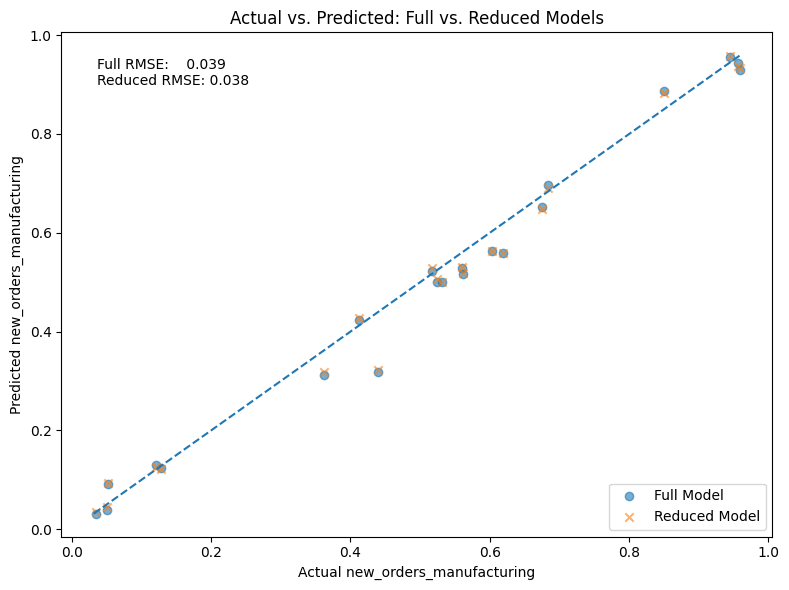

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot predictions
ax.scatter(y_te, y_pred_full, alpha=0.6, marker='o', label='Full Model')
ax.scatter(y_te, y_pred_red,  alpha=0.6, marker='x', label='Reduced Model')

# 45° reference line
lims = [min(y_te.min(), y_pred_full.min(), y_pred_red.min()),
        max(y_te.max(), y_pred_full.max(), y_pred_red.max())]
ax.plot(lims, lims, linestyle='--')

# Annotate model RMSEs
annotation = (
    f'Full RMSE:    {rmse_full:.3f}\n'
    f'Reduced RMSE: {rmse_red:.3f}'
)
ax.text(0.05, 0.95, annotation,
        transform=ax.transAxes,
        verticalalignment='top')

ax.set_xlabel('Actual new_orders_manufacturing')
ax.set_ylabel('Predicted new_orders_manufacturing')
ax.set_title('Actual vs. Predicted: Full vs. Reduced Models')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

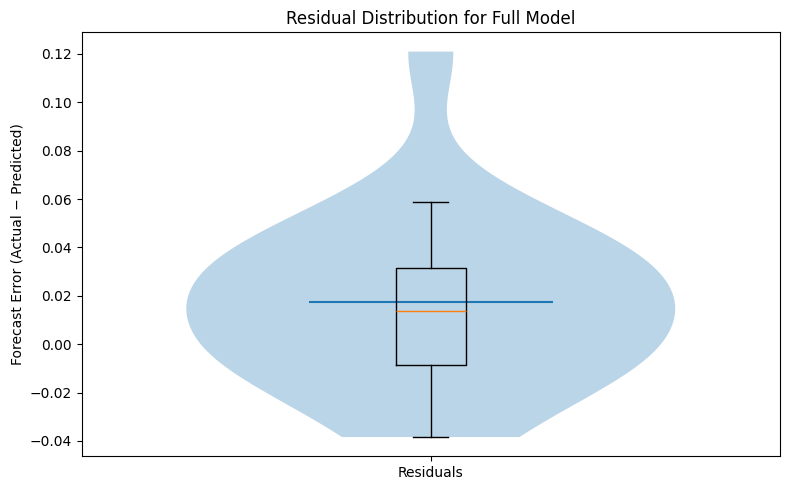

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct residuals and dates
resid_full = y_te - y_pred_full
dates = pd.to_datetime(df_nest.loc[y_te.index, 'Date'], format='%Y/%m')

# 1) Violin + Boxplot of residuals
fig, ax = plt.subplots(figsize=(8, 5))
ax.violinplot(resid_full, showmeans=True, showextrema=False, widths=0.7)
ax.boxplot(resid_full, positions=[1], widths=0.1, showfliers=False)
ax.set_xticks([1])
ax.set_xticklabels(['Residuals'])
ax.set_ylabel('Forecast Error (Actual − Predicted)')
ax.set_title('Residual Distribution for Full Model')
plt.tight_layout()
plt.show()

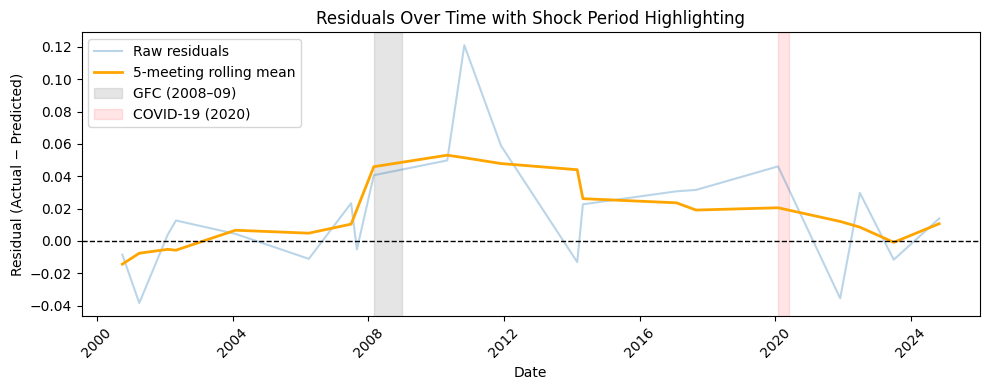

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Build a DataFrame of residuals + dates, then sort chronologically
df_err = pd.DataFrame({
    'Date': pd.to_datetime(df_nest.loc[y_te.index, 'Date'], format='%Y/%m'),
    'Residual': (y_te - y_pred_full).values
}).sort_values('Date')

dates_sorted = df_err['Date']
resid_sorted = df_err['Residual']

# 2) Compute a centered rolling mean (5‐meeting window)
rolling = resid_sorted.rolling(window=5, center=True, min_periods=1).mean()

# 3) Plot raw residuals, rolling mean, and shade shock periods
fig, ax = plt.subplots(figsize=(10, 4))

# Raw + smoothed residuals
ax.plot(dates_sorted, resid_sorted, alpha=0.3, label='Raw residuals')
ax.plot(dates_sorted, rolling,   color='orange', linewidth=2, label='5-meeting rolling mean')

# Shade Global Financial Crisis: Sep 2008 – Jun 2009
ax.axvspan(pd.Timestamp('2008-03-01'), pd.Timestamp('2009-01-01'),
           color='gray', alpha=0.2, label='GFC (2008–09)')

# Shade COVID-19 shock: Feb 2020 – Jun 2020
ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-06-01'),
           color='red', alpha=0.1, label='COVID-19 (2020)')

# Zero line and labels
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Residual (Actual − Predicted)')
ax.set_title('Residuals Over Time with Shock Period Highlighting')
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
import pandas as pd
import numpy as np

# 1) Compute residuals on the test set
residuals = y_te - y_pred_full

# 2) Build a DataFrame that ties together Date, cluster, actual, predicted, and error
error_df = pd.DataFrame({
    'Date':        df_nest.loc[y_te.index, 'Date'],        # e.g. "YYYY/MM"
    'Actual':      y_te.values,
    'Predicted':   y_pred_full,
    'Residual':    residuals.values
}, index=y_te.index)

# 3) Compute absolute error and sort
error_df['AbsError'] = np.abs(error_df['Residual'])
top10 = error_df.sort_values('AbsError', ascending=False).head(10)

print("Top 10 Largest Errors:")
print(top10[['Date','Actual','Predicted','Residual','AbsError']])

Top 10 Largest Errors:
        Date    Actual  Predicted  Residual  AbsError
95   2010/11  0.440111   0.319138  0.120973  0.120973
104  2011/12  0.618261   0.559392  0.058869  0.058869
90   2010/05  0.361865   0.312095  0.049770  0.049770
171  2020/02  0.562171   0.516097  0.046074  0.046074
70   2008/03  0.602944   0.562331  0.040614  0.040614
11   2001/04  0.052621   0.091009 -0.038388  0.038388
186  2021/12  0.850436   0.885930 -0.035494  0.035494
151  2017/09  0.560016   0.528485  0.031531  0.031531
146  2017/02  0.530958   0.500301  0.030657  0.030657
191  2022/07  0.959282   0.929598  0.029685  0.029685


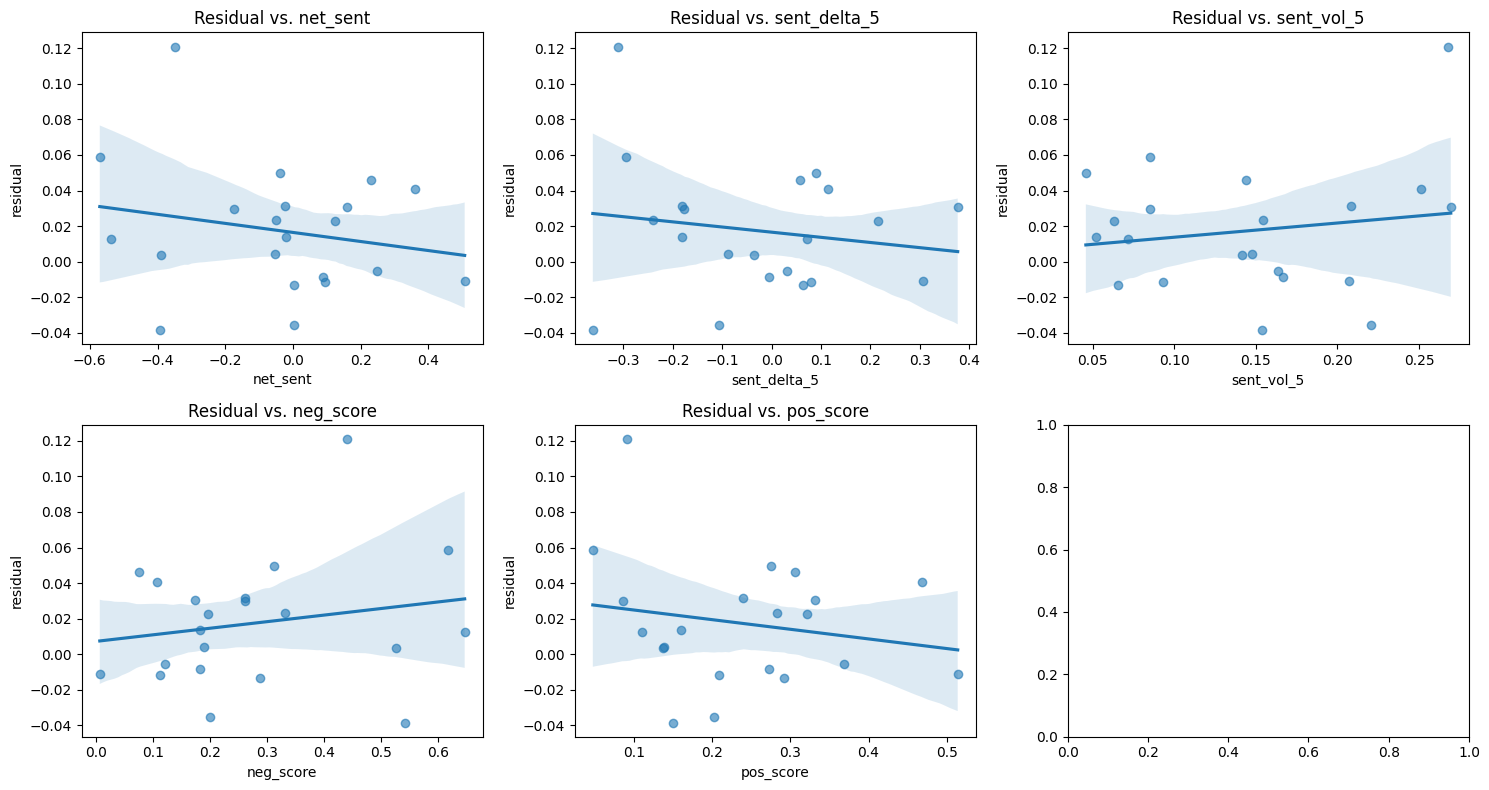

Pearson correlations:
  net_sent    : r = -0.202, p = 0.379
  sent_delta_5: r = -0.162, p = 0.483
  sent_vol_5  : r = 0.161, p = 0.486
  neg_score   : r = 0.188, p = 0.415
  pos_score   : r = -0.188, p = 0.414


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# 1) Reconstruct residuals
residuals = y_te - y_pred_full

# 2) Put residuals and sentiment into a DataFrame
err_sent = pd.DataFrame({
    'residual':   residuals.values,
    'net_sent':   df_nest.loc[y_te.index, 'net_sent'].values,
    'sent_delta_5': df_nest.loc[y_te.index, 'sent_delta_5'].values,
    'sent_vol_5':  df_nest.loc[y_te.index, 'sent_vol_5'].values,
    'neg_score':   df_nest.loc[y_te.index, 'neg_score'].values,
    'pos_score':   df_nest.loc[y_te.index, 'pos_score'].values,
})

# 3) Pairwise scatter + regression line
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feat in zip(axes.flat, ['net_sent','sent_delta_5','sent_vol_5','neg_score','pos_score']):
    sns.regplot(x=feat, y='residual', data=err_sent, ax=ax, scatter_kws={'alpha':0.6})
    ax.set_title(f'Residual vs. {feat}')
plt.tight_layout()
plt.show()

# 4) Compute correlations
print("Pearson correlations:")
for feat in ['net_sent','sent_delta_5','sent_vol_5','neg_score','pos_score']:
    r, p = pearsonr(err_sent['residual'], err_sent[feat])
    print(f"  {feat:12s}: r = {r:.3f}, p = {p:.3f}")